# Process NeuroPixels Electrophysiology data with DataJoint Elements

This notebook will walk through processing NeuroPixels array electrophysiology
data acquired with spikeGLX and processed with kilosort. While anyone can work
through this notebook to process electrophysiology data through DataJoint's
`element-array-ephys` pipeline, for a detailed tutorial about the fundamentals of
DataJoint including table types, make functions, and querying, please see the [DataJoint Tutorial](https://github.com/datajoint/datajoint-tutorials).

The DataJoint Python API and Element Array Electrophysiology offer a lot of features to support collaboration, automation, reproducibility, and visualizations.

For more information on these topics, please visit our documentation: 
 
- [DataJoint Core](https://datajoint.com/docs/core/): General principles

- DataJoint [Python](https://datajoint.com/docs/core/datajoint-python/) and
  [MATLAB](https://datajoint.com/docs/core/datajoint-matlab/) APIs: in-depth reviews of
  specifics

- [DataJoint Element Array Ephys](https://datajoint.com/docs/elements/element-array-ephys/):
  A modular pipeline for electrophysiology analysis


Let's start by importing the packages necessary to run this tutorial.

In [1]:
import os

if os.path.basename(os.getcwd()) == "notebooks":
    os.chdir("..")

import datajoint as dj
import datetime
import matplotlib.pyplot as plt
import numpy as np

### The Basics:

Any DataJoint workflow can be broken down into basic 3 parts:

- `Insert`
- `Populate` (or process)
- `Query`

In this demo we will:
- `Insert` metadata about an animal subject, recording session, and 
  parameters related to processing electrophysiology data.
- `Populate` tables with outputs of ephys recording data including LFPs, and spike
  sorted waveforms and units.
- `Query` the processed data from the database and plot waveform traces.

Each of these topics will be explained thoroughly in this notebook.

### Workflow diagram

This workflow is assembled from 4 DataJoint elements:
+ [element-lab](https://github.com/datajoint/element-lab)
+ [element-animal](https://github.com/datajoint/element-animal)
+ [element-session](https://github.com/datajoint/element-session)
+ [element-array-ephys](https://github.com/datajoint/element-array-ephys)

Each element declares its own schema in the database. These schemas can be imported like
any other Python package. This workflow is composed of schemas from each of the Elements
above and correspond to a module within `workflow_array_ephys.pipeline`.

The schema diagram is a good reference for understanding the order of the tables
within the workflow, as well as the corresponding table type.
Let's activate the elements and view the schema diagram.

In [2]:
from workflow_array_ephys.pipeline import subject, session, probe, ephys

[2023-06-30 03:34:11,767][WARNING]: lab.Project and related tables will be removed in a future version of Element Lab. Please use the project schema.
[2023-06-30 03:34:11,871][INFO]: Connecting root@fakeservices.datajoint.io:3306
[2023-06-30 03:34:11,899][INFO]: Connected root@fakeservices.datajoint.io:3306


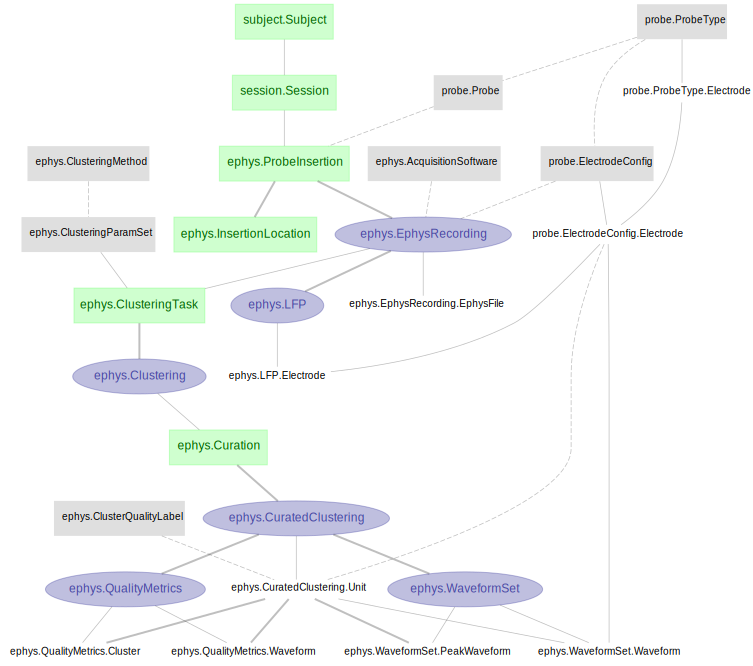

In [3]:
(
    dj.Diagram(subject.Subject)
    + dj.Diagram(session.Session)
    + dj.Diagram(probe)
    + dj.Diagram(ephys)
)

### Diagram Breakdown

While the diagram above seems complex at first, it becomes more clear when it's
approached as a hierarchy of tables that **define the order** in which the
workflow **expects to receive data** in each of its tables. 

- Tables with a green, or rectangular shape expect to receive data manually
  using the `insert()` function. The tables higher up in the diagram such as
  `subject.Subject()` should be the first to receive data. This ensures data
  integrity by preventing orphaned data within DataJoint schemas. 
- Tables with a purple oval or red circle can be automatically filled with relevant data
  by calling `populate()`. For example `ephys.EphysRecording` and its part-table
  `ephys.EphysRecording.EphysFile` are both populated with
  `ephys.EphysRecording.populate()`.
- Tables connected by a solid line depend on attributes (entries) in the table
  above it.

#### Table Types

There are 5 table types in DataJoint. Each of these appear in the diagram above.

- **Manual table**: green box, manually inserted table, expect new entries daily, e.g. `Subject`, `ProbeInsertion`.  
- **Lookup table**: gray box, pre inserted table, commonly used for general facts or parameters. e.g. `Strain`, `ClusteringMethod`, `ClusteringParamSet`.  
- **Imported table**: blue oval, auto-processing table, the processing depends on the importing of external files. e.g. process of `Clustering` requires output files from kilosort2.  
- **Computed table**: red circle, auto-processing table, the processing does not
  depend on files external to the database.  
- **Part table**: plain text, as an appendix to the master table, all the part
  entries of a given master entry represent a intact set of the master entry.
  e.g. `Unit` of a `CuratedClustering`.


## Starting the workflow: Insert

### Insert entries into manual tables

To view details about a table's dependencies and attributes, use functions `.describe()`
and `.heading`, respectively.

Let's start with the first table in the schema diagram (the `subject` table) and view
the table attributes we need to insert. There are two ways you can do this: *run each
of the two cells below*

In [4]:
print(subject.Subject.describe())

subject              : varchar(8)                   
---
subject_nickname     : varchar(64)                  
sex                  : enum('M','F','U')            
subject_birth_date   : date                         
subject_description  : varchar(1024)                



In [5]:
subject.Subject.heading

# 
subject              : varchar(8)                   # 
---
subject_nickname     : varchar(64)                  # 
sex                  : enum('M','F','U')            # 
subject_birth_date   : date                         # 
subject_description  : varchar(1024)                # 

The cells above show all attributes of the subject table. These are particularly useful functions if you are new to
DataJoint Elements and are unsure of the attributes required for each table. We will insert data into the
`subject.Subject` table.

In [6]:
subject.Subject.insert1(
    dict(
        subject='subject5',
        subject_nickname='subject5',
        subject_birth_date='2023-01-01',
        sex='U',
        subject_description='Example subject'
    )
)
subject.Subject()

subject,subject_nickname,sex,subject_birth_date,subject_description
subject5,subject5,U,2023-01-01,Example subject


Let's repeat the steps above for the `Session` table and see how the output varies between
`.describe` and `.heading`.

In [7]:
print(session.Session.describe())

-> subject.Subject
session_datetime     : datetime                     



In [8]:
session.Session.heading

# 
subject              : varchar(8)                   # 
session_datetime     : datetime                     # 

The cells above show the dependencies and attributes for the `session.Session` table.
Notice that `describe` shows the dependencies of the table on upstream tables. The
`Session` table depends on the upstream `Subject` table. 

Whereas `heading` lists all the attributes of the `Session` table, regardless of
whether they are declared in an upstream table. 

Here we will demonstrate a very useful way of inserting data by assigning the dictionary
to a variable `session_key`. This variable can be used to insert entries into tables that
contain the `Session` table as one of its attributes.

In [9]:
session_key = dict(subject='subject5', 
                   session_datetime=datetime.datetime.now())

session.Session.insert1(session_key)
session.Session()

subject,session_datetime
subject5,2023-06-30 03:34:20


The `SessionDirectory` table locates the relevant data files in a directory path
relative to the root directory defined in your `dj.config["custom"]`. More
information about `dj.config` is provided at the end of this tutorial and is
particularly useful for local deployments of this workflow.

In [10]:
print(session.SessionDirectory.describe())

-> session.Session
---
session_dir          : varchar(256)                 # Path to the data directory for a session



In [11]:
session.SessionDirectory.heading

# 
subject              : varchar(8)                   # 
session_datetime     : datetime                     # 
---
session_dir          : varchar(256)                 # Path to the data directory for a session

In [12]:
session.SessionDirectory.insert1(
    dict(
        session_key, 
        session_dir='subject5/session1'
    )
)
session.SessionDirectory()

subject,session_datetime,session_dir Path to the data directory for a session
subject5,2023-06-30 03:34:20,subject5/session1


As the workflow diagram indicates, the tables in the `probe` schemas need to
contain data before the tables in the `ephys` schema accept any data. Let's
start by inserting into `probe.Probe`, a table containing metadata about a
multielectrode probe. 

In [13]:
print(probe.Probe.describe())

# Represent a physical probe with unique identification
probe                : varchar(32)                  # unique identifier for this model of probe (e.g. serial number)
---
-> probe.ProbeType
probe_comment        : varchar(1000)                



In [14]:
probe.Probe.heading

# Represent a physical probe with unique identification
probe                : varchar(32)                  # unique identifier for this model of probe (e.g. serial number)
---
probe_type           : varchar(32)                  # e.g. neuropixels_1.0
probe_comment        : varchar(1000)                # 

In [15]:
probe.Probe.insert1(
    dict(probe="714000838", 
         probe_type="neuropixels 1.0 - 3B",
         probe_comment="Example probe")
)  # this info could be achieve from neuropixels meta file.
probe.Probe()

probe unique identifier for this model of probe (e.g. serial number),probe_type e.g. neuropixels_1.0,probe_comment
714000838,neuropixels 1.0 - 3B,Example probe


The probe metadata is used by the downstream `ProbeInsertion` table which we
insert data into in the cells below:

In [16]:
print(ephys.ProbeInsertion.describe())

# Probe insertion implanted into an animal for a given session.
-> session.Session
insertion_number     : tinyint unsigned             
---
-> probe.Probe



In [17]:
ephys.ProbeInsertion.heading

# Probe insertion implanted into an animal for a given session.
subject              : varchar(8)                   # 
session_datetime     : datetime                     # 
insertion_number     : tinyint unsigned             # 
---
probe                : varchar(32)                  # unique identifier for this model of probe (e.g. serial number)

In [18]:
ephys.ProbeInsertion.insert1(
    dict(
        session_key,
        insertion_number=1,
        probe="714000838",
    )
) # probe, subject, session_datetime needs to follow the restrictions of foreign keys.
ephys.ProbeInsertion()

subject,session_datetime,insertion_number,probe unique identifier for this model of probe (e.g. serial number)
subject5,2023-06-30 03:34:20,1,714000838


## Populate

### Automatically populate tables

`ephys.EphysRecording` is the first table in the pipeline that can be populated automatically.
If a table contains a part table, this part table is also populated during the
`populate()` call. `populate()` takes several arguments including the a session
key. This key restricts `populate()` to performing the operation on the session
of interest rather than all possible sessions which could be a time-intensive
process for databases with lots of entries.

Let's view the `ephys.EphysRecording` and its part table
`ephys.EphysRecording.EphysFile` and populate both through a single `populate()`
call.

In [19]:
ephys.EphysRecording.heading

# Ephys recording from a probe insertion for a given session.
subject              : varchar(8)                   # 
session_datetime     : datetime                     # 
insertion_number     : tinyint unsigned             # 
---
electrode_config_hash : uuid                         # 
acq_software         : varchar(24)                  # 
sampling_rate        : float                        # (Hz)
recording_datetime   : datetime                     # datetime of the recording from this probe
recording_duration   : float                        # (seconds) duration of the recording from this probe

In [20]:
ephys.EphysRecording.EphysFile.heading

# Paths of files of a given EphysRecording round.
subject              : varchar(8)                   # 
session_datetime     : datetime                     # 
insertion_number     : tinyint unsigned             # 
file_path            : varchar(255)                 # filepath relative to root data directory

In [21]:
ephys.EphysRecording()

subject,session_datetime,insertion_number,electrode_config_hash,acq_software,sampling_rate (Hz),recording_datetime datetime of the recording from this probe,recording_duration (seconds) duration of the recording from this probe


In [22]:
ephys.EphysRecording.EphysFile()

subject,session_datetime,insertion_number,file_path filepath relative to root data directory


In [23]:
ephys.EphysRecording.populate(session_key, display_progress=True)

EphysRecording:   0%|          | 0/1 [00:00<?, ?it/s]

EphysRecording: 100%|██████████| 1/1 [00:02<00:00,  2.07s/it]


Let's view the information was entered into each of these tables:

In [24]:
ephys.EphysRecording()

subject,session_datetime,insertion_number,electrode_config_hash,acq_software,sampling_rate (Hz),recording_datetime datetime of the recording from this probe,recording_duration (seconds) duration of the recording from this probe
subject5,2023-06-30 03:34:20,1,8d4cc6d8-a02d-42c8-bf27-7459c39ea0ee,SpikeGLX,30000.0,2018-07-03 20:32:28,338.666


In [25]:
ephys.EphysRecording.EphysFile()

subject,session_datetime,insertion_number,file_path filepath relative to root data directory
subject5,2023-06-30 03:34:20,1,subject5/session1/probe_1/npx_g0_t0.imec.ap.meta


We're almost ready to spike sort the data with `kilosort`. An important step before
processing is managing the parameters which will be used in that step. To do so, we will
define the kilosort parameters in a dictionary and insert them into a DataJoint table
`ClusteringParamSet`. This table keeps track of all combinations of your spike sorting
parameters. You can choose which parameters are used during processing in a later step.

Let's view the attributes and insert data into `ephys.ClusteringParamSet`.

In [26]:
ephys.ClusteringParamSet.heading

# Parameter set to be used in a clustering procedure
paramset_idx         : smallint                     # 
---
clustering_method    : varchar(16)                  # 
paramset_desc        : varchar(128)                 # 
param_set_hash       : uuid                         # 
params               : longblob                     # dictionary of all applicable parameters

In [27]:
# insert clustering task manually
params_ks = {
    "fs": 30000,
    "fshigh": 150,
    "minfr_goodchannels": 0.1,
    "Th": [10, 4],
    "lam": 10,
    "AUCsplit": 0.9,
    "minFR": 0.02,
    "momentum": [20, 400],
    "sigmaMask": 30,
    "ThPr": 8,
    "spkTh": -6,
    "reorder": 1,
    "nskip": 25,
    "GPU": 1,
    "Nfilt": 1024,
    "nfilt_factor": 4,
    "ntbuff": 64,
    "whiteningRange": 32,
    "nSkipCov": 25,
    "scaleproc": 200,
    "nPCs": 3,
    "useRAM": 0,
}
ephys.ClusteringParamSet.insert_new_params(
    clustering_method="kilosort2",
    paramset_idx=0,
    params=params_ks,
    paramset_desc="Spike sorting using Kilosort2",
)
ephys.ClusteringParamSet()

paramset_idx,clustering_method,paramset_desc,param_set_hash,params dictionary of all applicable parameters
0,kilosort2,Spike sorting using Kilosort2,de78cee1-526f-319e-b6d5-8a2ba04963d8,=BLOB=


Now that we've inserted kilosort parameters into the `ClusteringParamSet` table,
we're almost ready to sort our data. DataJoint uses a `ClusteringTask` table to
manage which `EphysRecording` and `ClusteringParamSet` should be used during processing. 

This table is important for defining several important aspects of
downstream processing. Let's view the attributes to get a better understanding. 

In [28]:
print(ephys.ClusteringTask.describe())

# Manual table for defining a clustering task ready to be run
-> ephys.EphysRecording
-> ephys.ClusteringParamSet
---
clustering_output_dir : varchar(255)                 # clustering output directory relative to the clustering root data directory
task_mode            : enum('load','trigger')       # 'load': load computed analysis results, 'trigger': trigger computation



In [29]:
ephys.ClusteringTask.heading

# Manual table for defining a clustering task ready to be run
subject              : varchar(8)                   # 
session_datetime     : datetime                     # 
insertion_number     : tinyint unsigned             # 
paramset_idx         : smallint                     # 
---
clustering_output_dir : varchar(255)                 # clustering output directory relative to the clustering root data directory
task_mode            : enum('load','trigger')       # 'load': load computed analysis results, 'trigger': trigger computation

The `ClusteringTask` table contains two important attributes: 
+ `paramset_idx` 
+ `task_mode` 

The `paramset_idx` attribute is tracks
your kilosort parameter sets. You can choose the parameter set using which 
you want spike sort ephys data. For example, `paramset_idx=0` may contain
default parameters for kilosort processing whereas `paramset_idx=1` contains your custom parameters for sorting. This
attribute tells the `Processing` table which set of parameters you are processing in a given `populate()`.

The `task_mode` attribute can be set to either `load` or `trigger`. When set to `load`,
running the processing step initiates a search for exisiting kilosort output files. When set to `trigger`, the
processing step will run kilosort on the raw data. 

In [30]:
ephys.ClusteringTask.insert1(
    dict(
        session_key,
        insertion_number=1,
        paramset_idx=0,
        task_mode='load', # load or trigger
        clustering_output_dir="subject5/session1/probe_1/kilosort2-5_1"
    )
)

Notice we set the `task_mode` to `load`. Let's call populate on the `Clustering`
table in the pipeline.

In [31]:
ephys.Clustering.populate(session_key, display_progress=True)

Clustering:   0%|          | 0/1 [00:00<?, ?it/s]

Clustering: 100%|██████████| 1/1 [00:00<00:00,  1.85it/s]


While spike sorting is completed in the above step, you can optionally curate
the output of image processing using the `Curation` table. For this demo, we
will simply use the results of the spike sorting output from the `Clustering` task.

In [32]:
ephys.Curation.heading

# Manual curation procedure
subject              : varchar(8)                   # 
session_datetime     : datetime                     # 
insertion_number     : tinyint unsigned             # 
paramset_idx         : smallint                     # 
curation_id          : int                          # 
---
curation_time        : datetime                     # time of generation of this set of curated clustering results
curation_output_dir  : varchar(255)                 # output directory of the curated results, relative to root data directory
quality_control      : tinyint                      # has this clustering result undergone quality control?
manual_curation      : tinyint                      # has manual curation been performed on this clustering result?
curation_note        : varchar(2000)                # 

In [33]:
clustering_key = (ephys.ClusteringTask & session_key).fetch1('KEY')
ephys.Curation().create1_from_clustering_task(clustering_key)

Once the `Curation` table receives an entry, we can populate the remaining
tables in the workflow including `CuratedClustering`, `WaveformSet`, and `LFP`. 

In [34]:
ephys.CuratedClustering.populate(session_key, display_progress=True)
ephys.LFP.populate(session_key, display_progress=True)
ephys.WaveformSet.populate(session_key, display_progress=True)

CuratedClustering:   0%|          | 0/1 [00:00<?, ?it/s]

/home/vscode/.local/lib/python3.9/site-packages/element_array_ephys/readers/kilosort.py:172: RuntimeWarning: invalid value encountered in divide
  self._data["spike_depths"] = np.sum(
WaveformSet: 100%|██████████| 1/1 [00:53<00:00, 53.70s/it]


Now that we've populated the tables in this workflow, there are one of
several next steps. If you have an existing workflow for
aligning waveforms to behavior data or other stimuli, you can easily
invoke `element-event` or define your custom DataJoint tables to extend the
pipeline.

In this tutorial, we will do some exploratory analysis by fetching the data from the database and creating a few plots.

## Query

This section focuses on working with data that is already in the
database. 

DataJoint queries allow you to view and import data from the database into a python
variable using the `fetch()` method. 

There are several important features supported by `fetch()`:
- By default, an empty `fetch()` imports a list of dictionaries containing all
  attributes of all entries in the table that is queried.
- **`fetch1()`**, on the other hand, imports a dictionary containing all attributes of
  one of the entries in the table. By default, if a table has multiple entries,
  `fetch1()` imports the first entry in the table.
- Both `fetch()` and `fetch1()` accept table attributes as an argument to query
  that particular attribute. For example `fetch1('fps')` will fetch the first
  value of the `fps` attribute if it exists in the table.
- Recommended best practice is to **restrict** queries by primary key attributes of the
  table to ensure the accuracy of imported data.
    - The most common restriction for entries in DataJoint tables is performed
      using the `&` operator. For example to fetch all session start times belonging to
      `subject1`, a possible query could be `subject1_sessions =
      (session.Session & "subject = 'subject1'").fetch("session_datetime")`.  
- `fetch()` can also be used to obtain the primary keys of a table. To fetch the primary
  keys of a table use `<table_name>.fetch("KEY")` syntax.

Let's walk through these concepts of querying by moving from simple to more
complex queries.

In [35]:
lfp_average = (ephys.LFP & "insertion_number = '1'").fetch1("lfp_mean")

In the query above, we fetch a single `lfp_mean` attribute from the `LFP` table.
We also restrict the query to insertion number 1.

Let's go ahead and plot the LFP mean.

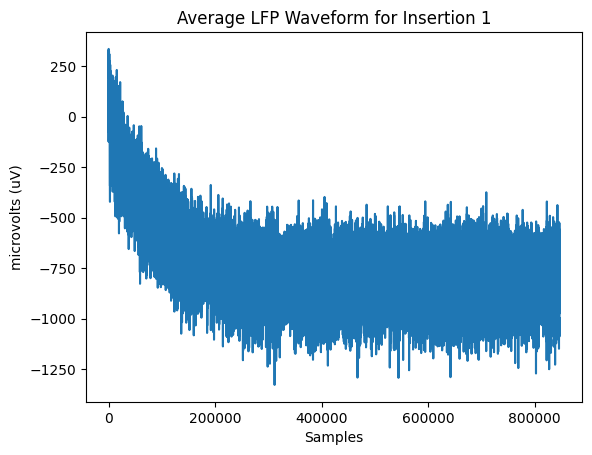

In [36]:
plt.plot(lfp_average)
plt.title("Average LFP Waveform for Insertion 1")
plt.xlabel("Samples")
plt.ylabel("microvolts (uV)");

DataJoint queries are a highly flexible tool to manipulate and visualize your data.
After all, visualizing traces or generating rasters is likely just the start of
your analysis workflow. This can also make the queries seem more complex at
first. However, we'll walk through them slowly to simplify their content in this notebook. 

The examples below perform several operations using DataJoint queries:
- Fetch the primary key attributes of all units that are in `insertion_number=1`.
- Use **multiple restrictions** to fetch timestamps and create a raster plot.
- Use a **join** operation and **multiple restrictions** to fetch a waveform
  trace, along with unit data to create a single waveform plot

In [37]:
insert_key = (ephys.ProbeInsertion & "insertion_number = '1'").fetch1("KEY")
units, unit_spiketimes = (ephys.CuratedClustering.Unit & insert_key & 'unit IN ("6","7","9","14","15","17","19")').fetch("unit", "spike_times")


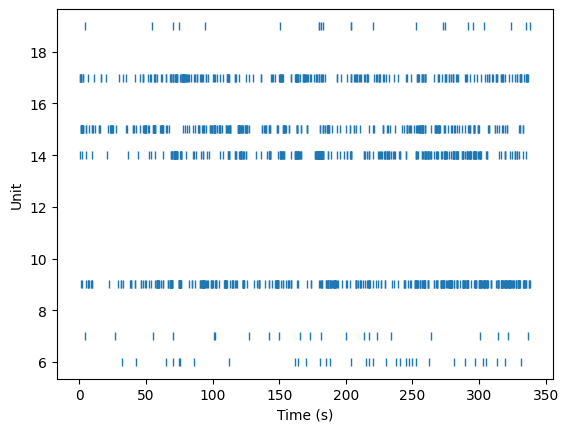

In [38]:
x = np.hstack(unit_spiketimes)
y = np.hstack([np.full_like(s, u) for u, s in zip(units, unit_spiketimes)])
plt.plot(x, y, "|")
plt.xlabel("Time (s)")
plt.ylabel("Unit");

In [39]:
unit_key = (ephys.CuratedClustering.Unit & insert_key & "unit = '15'").fetch1("KEY")
unit_data = (ephys.CuratedClustering.Unit * ephys.WaveformSet.PeakWaveform & unit_key).fetch1()

In [40]:
unit_data

{'subject': 'subject5',
 'session_datetime': datetime.datetime(2023, 6, 30, 3, 34, 20),
 'insertion_number': 1,
 'paramset_idx': 0,
 'curation_id': 1,
 'unit': 15,
 'electrode_config_hash': UUID('8d4cc6d8-a02d-42c8-bf27-7459c39ea0ee'),
 'probe_type': 'neuropixels 1.0 - 3A',
 'electrode': 92,
 'cluster_quality_label': 'noise',
 'spike_count': 292,
 'spike_times': array([  1.02606667,   1.19973333,   1.5044    ,   1.52283333,
          1.86786667,   1.8688    ,   1.8806    ,   1.88553333,
          2.0581    ,   2.76826667,   2.89186667,   2.9311    ,
          4.8753    ,   5.2964    ,   7.02266667,   9.65273333,
          9.81373333,  10.22443333,  11.96146667,  15.07173333,
         15.08983333,  15.78326667,  21.30936667,  22.7549    ,
         23.5582    ,  23.6582    ,  23.87043333,  24.16726667,
         24.25456667,  24.2671    ,  25.0249    ,  27.89116667,
         35.3036    ,  36.0171    ,  40.00396667,  40.0873    ,
         41.015     ,  42.70086667,  45.8682    ,  47.9291  

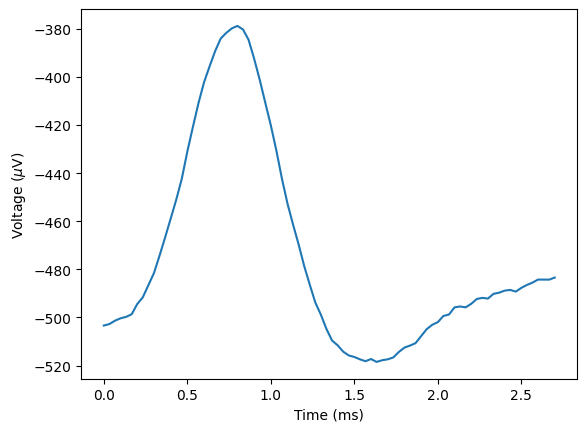

In [41]:
sampling_rate = (ephys.EphysRecording & insert_key).fetch1(
    "sampling_rate"
) / 1000  # in kHz
plt.plot(
    np.r_[: unit_data["peak_electrode_waveform"].size] * 1 / sampling_rate,
    unit_data["peak_electrode_waveform"],
)
plt.xlabel("Time (ms)")
plt.ylabel(r"Voltage ($\mu$V)");

To run this tutorial notebook on your own data, please use the following steps:
- Download the mysql-docker image for DataJoint and run the container according to the
  instructions provide in the repository.
- Create a fork of this repository to your GitHub account.
- Clone the repository and open the files using your IDE.
- Add a code cell immediately after the first code cell in the notebook - we will setup
  the local connection using this cell. In this cell, type in the following code. 

```python
import datajoint as dj
dj.config["database.host"] = "localhost"
dj.config["database.user"] = "<your-username>"
dj.config["database.password"] = "<your-password>"
dj.config["custom"] = {"imaging_root_data_dir": "path/to/your/data/dir",
"database_prefix": "<your-username_>"}
dj.config.save_local()
dj.conn()
```

- Run this code cell and proceed with the rest of the notebook.